**Table of contents**<a id='toc0_'></a>    
- [Fitting the ZnPc XRR Data](#toc1_)    
  - [Fit 250 eV Data](#toc1_1_)    
    - [Load the 250 eV data](#toc1_1_1_)    
    - [Masking 250 eV](#toc1_1_2_)    
    - [Construct the slab structure for the data](#toc1_1_3_)    
    - [Construct the Objective Function](#toc1_1_4_)    
      - [Constraining the parameters](#toc1_1_4_1_)    
    - [Fitting the data](#toc1_1_5_)    
  - [Fit 283.7 eV Data](#toc1_2_)    
    - [Load the 283.7 eV data](#toc1_2_1_)    
      - [Various Masking Attempts](#toc1_2_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
from sys import path as syspath
from pathlib import Path

syspath.append(str(Path().home() / "pyref" / "src"))

import pyref as rf
import seaborn as sns
import matplotlib.pyplot as plt

# <a id='toc1_'></a>[Fitting the ZnPc XRR Data](#toc0_)
**Harlan Heilman**
---
## <a id='toc1_1_'></a>[Fit 250 eV Data](#toc0_)

The steps to fit the ZnPc XRR data are as follows:
1. Load the 250 eV data
    1. Convert the csv file to a pandas dataframe
    2. Plot the data and see if it looks reasonable - If not, mask the data
    3. Convert the data to a ReflectDataSet
2. Construct the slab structure for the data
    1. Vacuum | ZnPc | Amorphous Carbon | SiO2 | Si
3. Construct the Objective Function
    1. Create models for sp polarization
    2. Create objective functions for 250 eV
    3. Add thick - rough constraints to the prior for each layer
4. Fit the data

### <a id='toc1_1_1_'></a>[Load the 250 eV data](#toc0_)

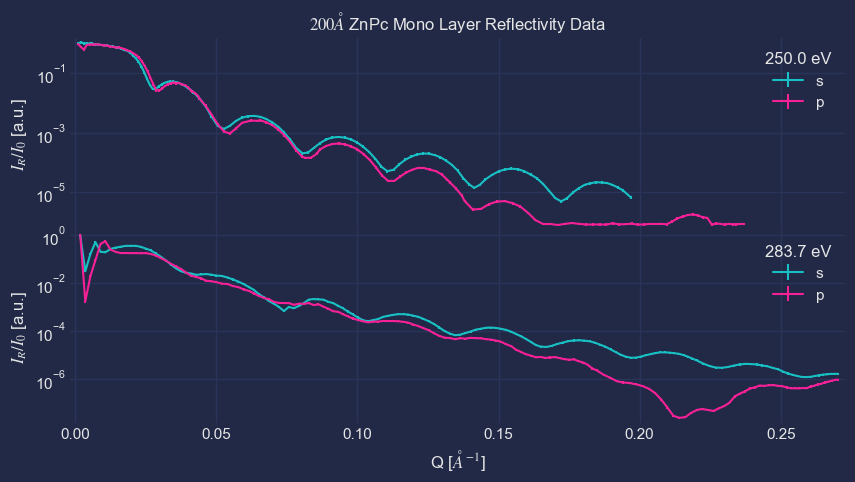

In [2]:
db = rf.db()

znpc_oc = db.get_oc("C32H16N8Zn")
znpc_mono = {
    "250": {
        "s": db.get_refl("zrt_250.0_100.csv", "ZnPc"),
        "p": db.get_refl("zrt_250.0_190.csv", "ZnPc"),
        },
    "283.7": {
        "s": db.get_refl("ZnPc_283.7_100.0 (CCD Scan 82865).parquet", "ZnPc"),
        "p": db.get_refl("ZnPc_283.7_190.0 (CCD Scan 82869).parquet", "ZnPc"),
        },
}
fig, ax = plt.subplots(nrows = 2, sharex=True, gridspec_kw={"hspace":0})
znpc_mono["250"]["s"].plot(ax = ax[0], x = "Q", y = "Refl", yerr="Err")
znpc_mono["250"]["p"].plot(ax = ax[0], x = "Q", y = "Refl", yerr = "Err")
znpc_mono["283.7"]["s"].plot(ax = ax[1], x = "Q", y = "Refl", yerr = "Err")
znpc_mono["283.7"]["p"].plot(ax = ax[1], x = "Q", y = "Refl", yerr = "Err")
ax[0].set(
    title = r"$200 \AA$ ZnPc Mono Layer Reflectivity Data",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)
ax[1].set(
    xlabel = r"Q [$\AA^{-1}$]",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)
ax[0].legend(title = "250.0 eV", labels = ["s", "p"])
ax[1].legend(title = "283.7 eV", labels = ["s", "p"])

### <a id='toc1_1_2_'></a>[Masking 250 eV](#toc0_)

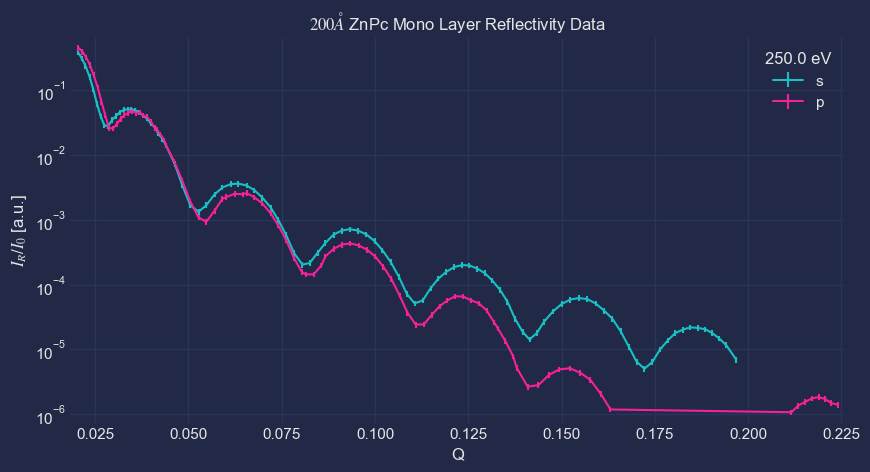

In [20]:
znpc_mono_250_s = rf.smart_mask(znpc_mono["250"]["s"])
znpc_mono_250_p = rf.smart_mask(znpc_mono["250"]["p"], pol = "p")

fig, ax = plt.subplots()
znpc_mono_250_s.plot(ax = ax, x = "Q", y = "Refl", yerr="Err")
znpc_mono_250_p.plot(ax = ax, x = "Q", y = "Refl", yerr = "Err")
ax.set(
    title = r"$200 \AA$ ZnPc Mono Layer Reflectivity Data",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)
ax.legend(title = "250.0 eV", labels = ["s", "p"])

znpc_mono_250 = rf.to_refnx_dataset(znpc_mono_250_s, pol = "sp", second_pol=znpc_mono_250_p)

### <a id='toc1_1_3_'></a>[Construct the slab structure for the data](#toc0_)

I have allready fit this structure several times. So I will just load the structure from a .json file. 

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

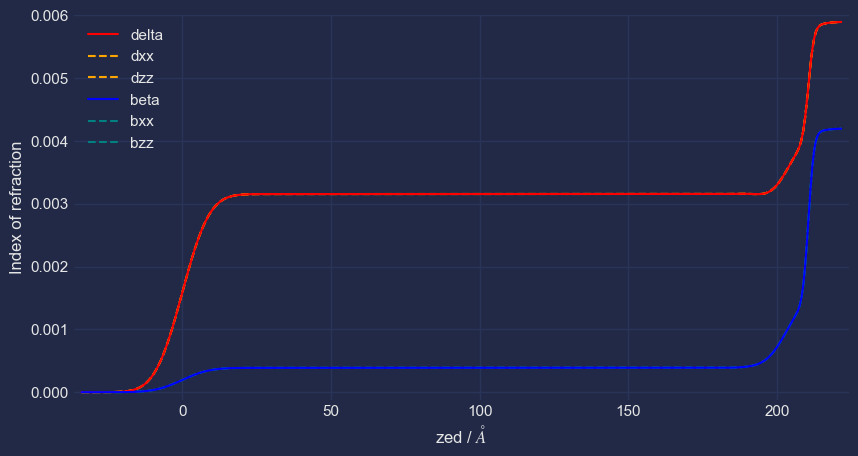

In [28]:
from pypxr.structure import *
from pypxr.reflectivity import *
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective
from refnx._lib.emcee.moves.de import *


# Collect structure parameters
znpc_mono_struct_file = db.get_struct("ZnPc_RoomTemp")
znpc_oc = db.get_oc("C32H16N8Zn")

# generate slabs
en = 250
vac = PXR_MaterialSLD("", 0, en)(0, 0)
si = PXR_MaterialSLD("Si", 2.3, en, name="Si")(znpc_mono_struct_file["Si"]["thickness"],znpc_mono_struct_file["Si"]["roughness"])
sio2 = PXR_MaterialSLD("SiO2", 1.6, en, name="SiO2")(znpc_mono_struct_file["SiO2"]["thickness"],znpc_mono_struct_file["SiO2"]["roughness"])
c_amor = PXR_MaterialSLD("C", 1.6, en, name="C_Amorphous")(znpc_mono_struct_file["C"]["thickness"], znpc_mono_struct_file["C"]["roughness"])
znpc = PXR_MaterialSLD("C32H16N8Zn",1.6, en, name="ZnPc")(znpc_mono_struct_file["C32H16N8Zn"]["thickness"], znpc_mono_struct_file["C32H16N8Zn"]["roughness"])

# generate structure
struct_250 = vac | znpc | c_amor | sio2 | si
struct_250.plot()

### <a id='toc1_1_4_'></a>[Construct the Objective Function](#toc0_)

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

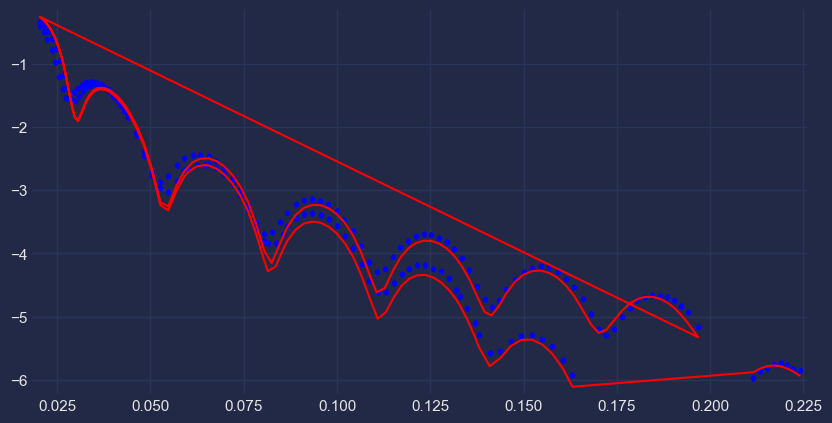

In [31]:
# Building the model from the slab structure

model_250 = PXR_ReflectModel(struct_250, pol = "sp", energy = en, name = "ZnPc Mono Layer 250eV")
model_250.scale.setp(vary = True, bounds = (0.6, 1.2))
model_250.bkg.setp(vary = True, bounds = (1e-9, 1e-6))

# Building the objective function
from pyref.fitting.logp import LogpExtra_rough
obj_250 = Objective(model_250, znpc_mono_250, transform=Transform("logY"))
logp = LogpExtra_rough(obj_250)
obj_250.logp_extra = logp

obj_250.plot()

#### <a id='toc1_1_4_1_'></a>[Constraining the parameters](#toc0_)

The log prior extra ensures that the roughness is allways less than the thickness of the material. Now, we need to ensure that the thickness and roughness are within a series of bounds.

In [36]:
# si slabs
si.thick.setp(vary = False)
si.rough.setp(vary = False)

# sio2 slabs
sio2.thick.setp(vary = True, bounds = (sio2.thick.value*.5, sio2.thick.value*1.5)) # These are well constrained allready by the Bare si fitting
sio2.rough.setp(vary = True, bounds = (sio2.rough.value*.5, sio2.rough.value*1.5))
sio2.sld.density.setp(vary = True, bounds = (sio2.sld.density.value*.5, sio2.sld.density.value*1.5))

# c_amor slabs
c_amor.thick.setp(vary = True, bounds = (c_amor.thick.value*.5, c_amor.thick.value*1.5)) # These are well constrained allready by the Bare si fitting
c_amor.rough.setp(vary = True, bounds = (c_amor.rough.value*.5, c_amor.rough.value*1.5))
c_amor.sld.density.setp(vary = True, bounds = (c_amor.sld.density.value*.5, c_amor.sld.density.value*1.5))

# znpc slabs
znpc.thick.setp(vary = True, bounds = (100, 220)) 
znpc.rough.setp(vary = True, bounds = (0, 20))
znpc.sld.density.setp(vary = True, bounds = (0.5, 2))

### <a id='toc1_1_5_'></a>[Fitting the data](#toc0_)

100%|██████████| 200/200 [01:17<00:00,  2.59it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=0.896613 +/- 0.0606, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=2.03713e-07 +/- 9.04e-08, bounds=[1e-09, 1e-06]>
<Parameter: 'ZnPc_thick'  , value=197.089 +/- 1.04 , bounds=[100.0, 220.0]>
<Parameter:     'rho'     , value=1.28331 +/- 0.0178, bounds=[0.5, 2.0]>
<Parameter: 'ZnPc_rough'  , value=4.97937 +/- 0.688, bounds=[0.0, 20.0]>
<Parameter:'C_Amorphous_thick', value=6.37058 +/- 0.91 , bounds=[3.048794250868106, 9.146382752604318]>
<Parameter:     'rho'     , value=2.00064 +/- 0.36 , bounds=[0.8, 2.4000000000000004]>
<Parameter:'C_Amorphous_rough', value=3.51729 +/- 0.84 , bounds=[1.9969730835240163, 5.990919250572048]>
<Parameter: 'SiO2_thick'  , value=7.76913 +/- 0.907, bounds=[4.003750135980335, 12.011250407941004]>
<Parameter:     'rho'     , value=1.64918 +/- 0.158, bounds=[0.8, 2.4000000000000004]>
<Parameter: 'SiO2_rough'  , 

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

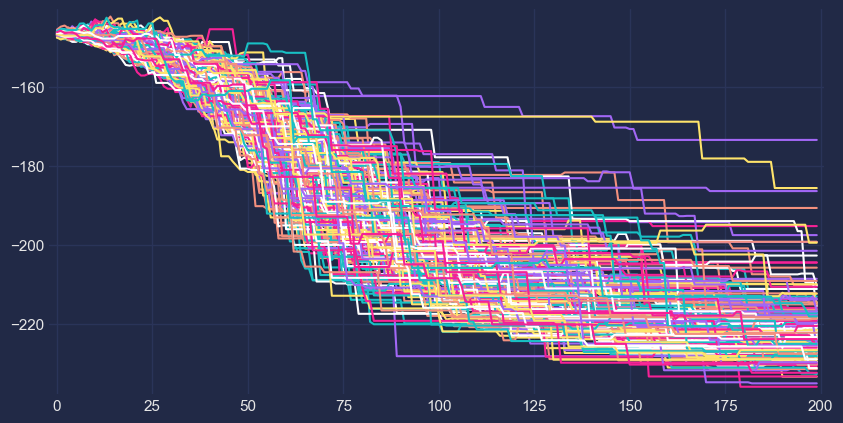

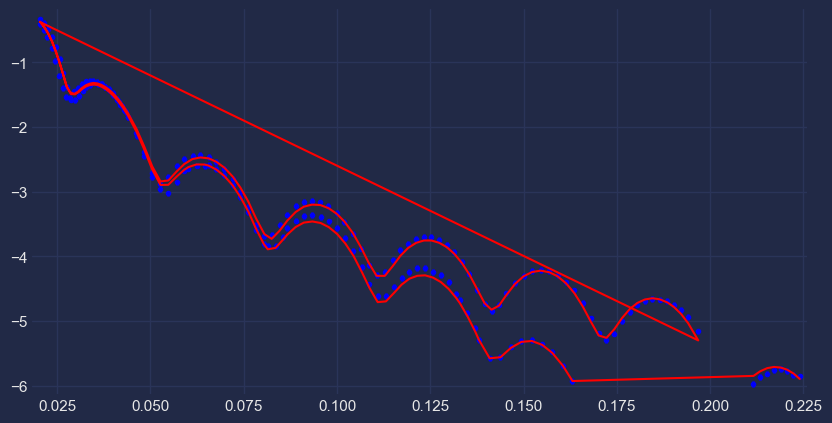

In [37]:
move = [(DEMove(sigma=1e-7), 0.95), (DEMove(sigma=1e-7), 0.05)]
nwalkers = 200
nsteps = 200
random_state = 1

fitter = CurveFitter(obj_250, nwalkers=nwalkers, moves = move)
fitter.initialise("jitter")
chain = fitter.sample(int(nwalkers), random_state=random_state)
lp = fitter.logpost
plt.plot(-lp)

print(obj_250.varying_parameters())
obj_250.plot()

In [51]:
# Fitted Structure Parameters

# Si
si_thick = si.thick.value
si_rough = si.rough.value

# SiO2
sio2_thick = sio2.thick.value
sio2_rough = sio2.rough.value
sio2_density = sio2.sld.density.value

# C Amorphous
c_amor_thick = c_amor.thick.value
c_amor_rough = c_amor.rough.value
c_amor_density = c_amor.sld.density.value

# ZnPc
znpc_thick = znpc.thick.value
znpc_rough = znpc.rough.value

## <a id='toc1_2_'></a>[Fit 283.7 eV Data](#toc0_)

### <a id='toc1_2_1_'></a>[Load the 283.7 eV data](#toc0_)

[Text(0.5, 1.0, '$200 \\AA$ ZnPc Mono Layer Reflectivity Data'),
 Text(0, 0.5, '$I_R / I_0$ [a.u.]'),
 None]

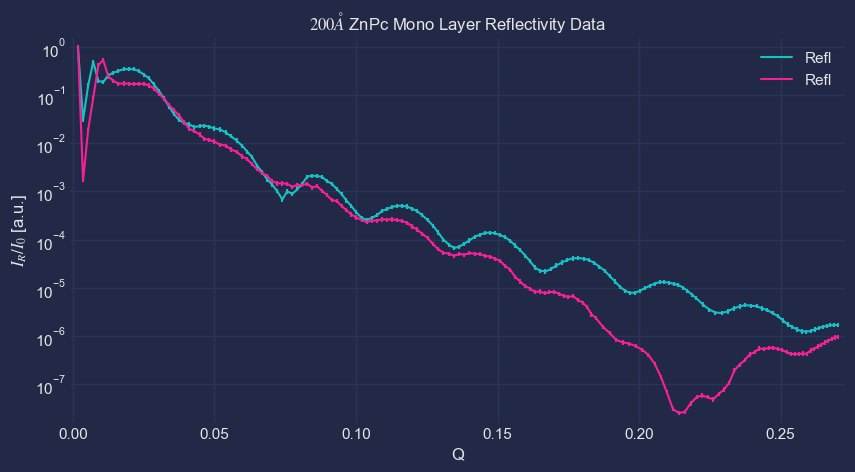

In [42]:
fig, ax = plt.subplots()

znpc_mono_283p7_s = znpc_mono["283.7"]["s"]
znpc_mono_283p7_p = znpc_mono["283.7"]["p"]

znpc_mono_283p7_s.plot(ax = ax, x = "Q", y = "Refl", yerr = "Err")
znpc_mono_283p7_p.plot(ax = ax, x = "Q", y = "Refl", yerr = "Err")
ax.set(
    title = r"$200 \AA$ ZnPc Mono Layer Reflectivity Data",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)

#### <a id='toc1_2_1_1_'></a>[Various Masking Attempts](#toc0_)

[Text(0.5, 0, 'Q [$\\AA^{-1}$]'), Text(0, 0.5, '$I_R / I_0$ [a.u.]'), None]

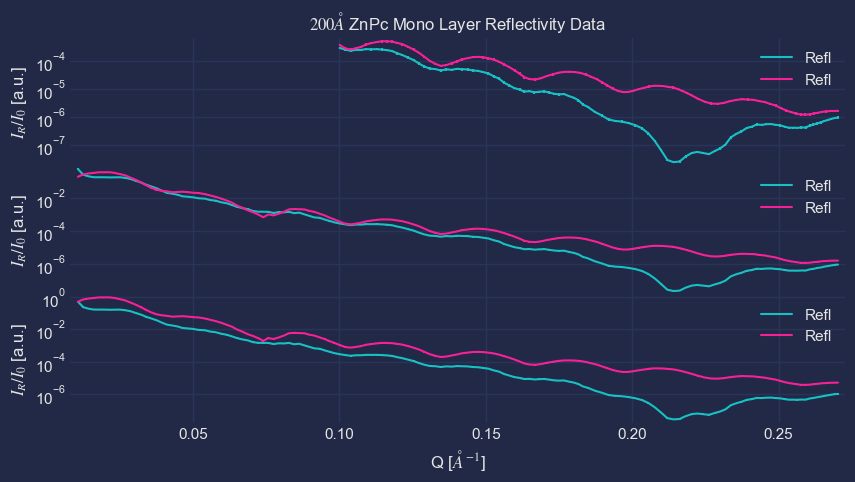

In [48]:
fig, ax = plt.subplots(nrows = 3, sharex=True, gridspec_kw={"hspace":0})
# (Extream Remove Low Q) Masking <.1

znpc_mono_283p7_s_extreme = znpc_mono_283p7_s[znpc_mono_283p7_s["Q"] > .1]
znpc_mono_283p7_p_extreme = znpc_mono_283p7_p[znpc_mono_283p7_p["Q"] > .1]

znpc_mono_283p7_p_extreme.plot(ax = ax[0], x = "Q", y = "Refl", yerr = "Err")
znpc_mono_283p7_s_extreme.plot(ax = ax[0], x = "Q", y = "Refl", yerr = "Err")
ax[0].set(
    title = r"$200 \AA$ ZnPc Mono Layer Reflectivity Data",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)

# (Remove Low Q) Masking first 5 points
znpc_mono_283p7_s_lowq = znpc_mono_283p7_s.iloc[5:]
znpc_mono_283p7_p_lowq = znpc_mono_283p7_p.iloc[5:]

znpc_mono_283p7_p_lowq.plot(ax = ax[1], x = "Q", y = "Refl", yerr = "Err")
znpc_mono_283p7_s_lowq.plot(ax = ax[1], x = "Q", y = "Refl", yerr = "Err")
ax[1].set(
    xlabel = r"Q [$\AA^{-1}$]",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)

# (Remove Low Q + Scale)

znpc_mono_283p7_s_lowq_scale = znpc_mono_283p7_s_lowq.copy()
znpc_mono_283p7_p_lowq_scale = znpc_mono_283p7_p_lowq.copy()
scale = znpc_mono_283p7_p_lowq_scale["Refl"].iloc[0] / znpc_mono_283p7_s_lowq_scale["Refl"].iloc[0]
znpc_mono_283p7_s_lowq_scale["Refl"] *= scale
znpc_mono_283p7_s_lowq_scale["Err"] *= scale

znpc_mono_283p7_p_lowq_scale.plot(ax = ax[2], x = "Q", y = "Refl", yerr = "Err")
znpc_mono_283p7_s_lowq_scale.plot(ax = ax[2], x = "Q", y = "Refl", yerr = "Err")
ax[2].set(
    xlabel = r"Q [$\AA^{-1}$]",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)


#### Renormalization To The Model

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

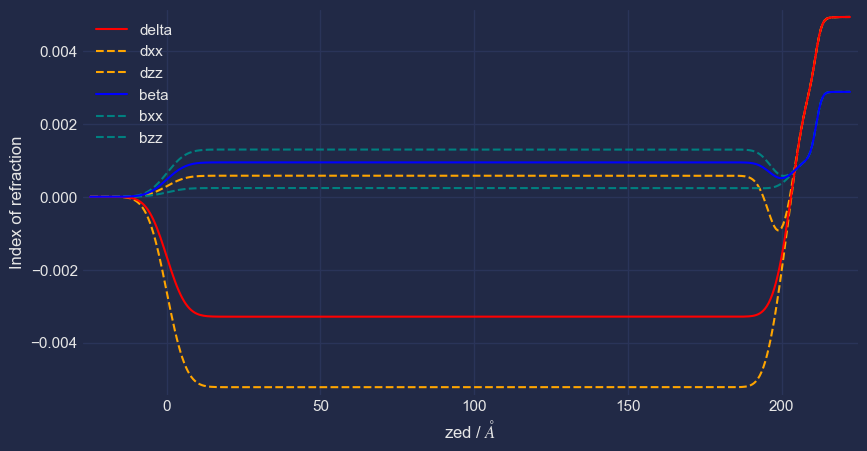

In [59]:
en = 283.7
vac = PXR_MaterialSLD("", 0, en)(0, 0)
si_1 = PXR_MaterialSLD("Si", si.sld.density, en, name="Si")(si_thick,si_rough)
sio2_1 = PXR_MaterialSLD("SiO2", sio2.sld.density, en, name="SiO2")(sio2_thick,sio2_rough)
c_amor_1 = PXR_MaterialSLD("C", c_amor.sld.density, en, name="C_Amorphous")(c_amor_thick, c_amor_rough)

n = np.array([znpc_oc["zz"].n(en), znpc_oc["xx"].n(en)])
znpc_1 = PXR_SLD(n, symmetry="uni", name = "ZnPc")(znpc_thick, znpc_rough)

struct_283p7 = vac | znpc_1 | c_amor_1 | sio2_1 | si_1
struct_283p7.plot()

c:\Users\hduva\mambaforge\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:115: RuntimeWarning: invalid value encountered in arcsin
  theta_exp = np.pi/2 - np.arcsin(flatq[:]  / (2*k0))
c:\Users\hduva\mambaforge\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:196: RuntimeWarning: invalid value encountered in sqrt
  kz_ord = np.sqrt(e_o * k0**2 - k_par[:]**2)#, dtype=np.complex128)
c:\Users\hduva\mambaforge\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:240: RuntimeWarning: invalid value encountered in divide
  knorm = kvec / kdiv [:,:,None]#(np.linalg.norm(kvec,axis=-1)[:,:,None])
c:\Users\hduva\mambaforge\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:251: RuntimeWarning: invalid value encountered in divide
  dpol_temp[:,0,:] = np.subtract(opticaxis[None, :], ((1 + nu)/(1+nu*kpol[:, 0, None]**2))*kpol[:, 0, None] * knorm[:, 0, :])
c:\Users\hduva\mambaforge\envs\refl\Lib\site-packages\pypxr\_uniaxial_reflect.py:252: RuntimeWarning: invalid value encountered

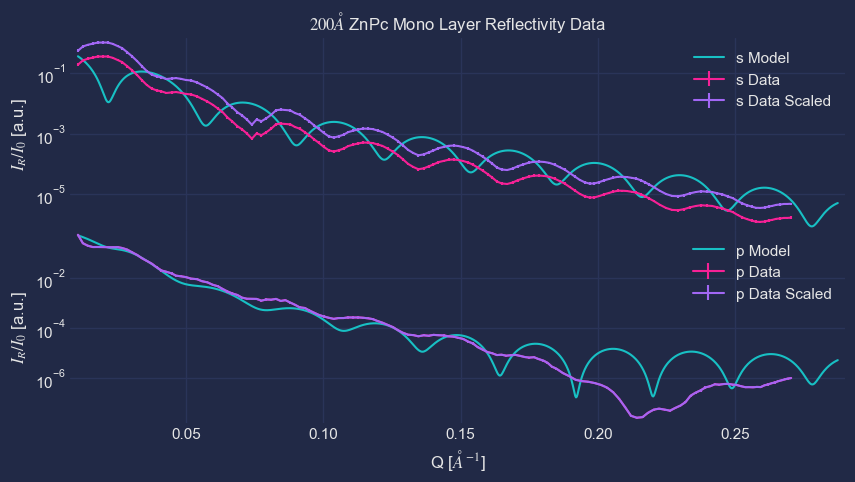

In [60]:
model_283p7_s = PXR_ReflectModel(struct_283p7, pol = "s", energy = en, name = "ZnPc Mono Layer 283.7eV")
model_283p7_p = PXR_ReflectModel(struct_283p7, pol = "p", energy = en, name = "ZnPc Mono Layer 283.7eV")

first_q = znpc_mono_283p7_p_lowq["Q"].iloc[0]

fig, ax = plt.subplots(nrows = 2, sharex=True, gridspec_kw={"hspace":0})
q = np.linspace(first_q, 0.3, 1000)

ax[0].plot(q, model_283p7_s(q), label = "s Model")
ax[1].plot(q, model_283p7_p(q), label = "p Model")
znpc_mono_283p7_s_lowq.plot(ax = ax[0], x = "Q", y = "Refl", yerr = "Err", label = "s Data")
znpc_mono_283p7_p_lowq.plot(ax = ax[1], x = "Q", y = "Refl", yerr = "Err", label = "p Data")
znpc_mono_283p7_p_lowq_scale.plot(ax = ax[1], x = "Q", y = "Refl", yerr = "Err", label = "p Data Scaled")
znpc_mono_283p7_s_lowq_scale.plot(ax = ax[0], x = "Q", y = "Refl", yerr = "Err", label = "s Data Scaled")

ax[0].set(
    title = r"$200 \AA$ ZnPc Mono Layer Reflectivity Data",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)
ax[1].set(
    xlabel = r"Q [$\AA^{-1}$]",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)
ax[0].legend()
ax[1].legend()
